In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

from src.semi_sub_utils import  log_pointwise_predictive_likelihood
from src.semi_subspace import *
from src.base_models import SimpleCnn, NllLoss
from src.pyro_models import pyroSemiSubspace
from src.plot import plot_predictive_regression, plot_curve_solutions_regression, plot_subspace, plot_subspace_solution_regression_pyro

from pyro.infer.autoguide import init_to_sample
from pyro.poutine.indep_messenger import IndepMessenger
from copy import deepcopy
import arviz as az


import torch
import torchvision
import torch.nn as nn
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
# from pydicom import dcmread
import pytorch_lightning as pl
from torchmetrics import MetricCollection, AUROC, CalibrationError, SumMetric
import wandb
from utils_datamodel.pl_utils import MelanomDataModuleFromSplit
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, Callback
from src.plot import plot_subspace
from src.semiSub_model import cudaIter
from src.curve_models import CurveModel, CurveLogger
from src.plot import exclude_project_code_dirs
from tqdm import tqdm
from src.semi_sub_utils import get_curve_space_torch
from src.semiSub_model import getModel
import pyro
from src.ess import SemiSubEllipticalSliceSampling
from utils_datamodel.utils import FastFillTensorDataLoader
import torchmetrics

# %load_ext tensorboard
sns.set_style("darkgrid")
if torch.cuda.is_available() and 1:
    print("Use cuda. Device: ", torch.cuda.get_device_name(torch.cuda.current_device()))
    device = torch.device('cuda', torch.cuda.current_device())
else:
    device = torch.device('cpu')
print("Device: ", device)
%load_ext autoreload
%autoreload 2
%env WANDB_BASE_URL http://141.37.176.203:8080
%env WANDB_NOTEBOOK_NAME ./train_semi_subspace_melanoma.ipynb

fig_width_pt = 234.8  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
figsize = [fig_width,fig_height]

fig_width_pt = 487.8  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
figsize_l = [fig_width,fig_height]
print("Figure size=", figsize)
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    # "text.latex.preamble": r'\usepackage{amsfonts}',
    "font.family": "Nimbus Sans",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize":figsize
}
plt.rcParams.update(tex_fonts)

Use cuda. Device:  NVIDIA GeForce RTX 3080 Ti
Device:  cuda:0
Use cuda. Device:  NVIDIA GeForce RTX 3080 Ti
Device:  cuda:0
env: WANDB_BASE_URL=http://141.37.176.203:8080
env: WANDB_NOTEBOOK_NAME=./train_semi_subspace_melanoma.ipynb
Figure size= [3.2489276324892766, 2.0079477038671003]


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


## Load data

In [ ]:
wandb_logger = WandbLogger(project='semi_subspace_mela_speed', log_model=False, name='load_data', group="SimpleCnnCurve", resume='never')       
transform = nn.Sequential(torchvision.transforms.ConvertImageDtype(torch.float32),
                            torchvision.transforms.Normalize((0.8061, 0.6210, 0.5914), (0.1484, 0.1748, 0.1999)))
transform = torch.jit.trace(transform, torch.randint(0, 255, (3, 128, 128), dtype=torch.uint8))
dm = MelanomDataModuleFromSplit(wandb_logger=wandb_logger,
                                # **vars(args),
                                data_dir="dataset/siim_isic",
                                batch_size=256,
                                reuse_artifact=False,
                                meta_features=['age_approx'],
                                split=1,
                                transform_test=transform,
                                transform_train=transform)
dm.prepare_data()
dm.setup()
u, x, y = [], [], []
for (uu, xx), yy in dm.test_dataloader():
    u.append(uu)
    x.append(xx)
    y.append(yy)
y = torch.hstack(y)
print(len(y))
wandb.finish()

## train curve model and log time 

In [4]:
from time import time

In [5]:
# define a metric we are interested in the best of
wandb_logger = WandbLogger(project='semi_subspace_mela_speed', log_model=False, name='Load data',
                            group="SimpleCnnCurve", resume='never')
# prepare data for fast computation 
transform = nn.Sequential(torchvision.transforms.ConvertImageDtype(torch.float32),
                            torchvision.transforms.Normalize((0.8061, 0.6210, 0.5914), (0.1484, 0.1748, 0.1999)))
transform = torch.jit.trace(transform, torch.randint(0, 255, (3, 128, 128), dtype=torch.uint8))
dm = MelanomDataModuleFromSplit(wandb_logger=wandb_logger,
                                # **vars(args),
                                data_dir="dataset/siim_isic",
                                batch_size=256,
                                reuse_artifact=True,
                                meta_features=['age_approx'],
                                split=1,
                                transform_test=transform,
                                transform_train=transform)
dm.prepare_data()
dm.setup()

cuda_loader_val = cudaIter(device=device, bs=551, data_set=dm.ds_val)
u, x, y = [], [], []
for (uu, xx), yy in dm.train_dataloader():
    u.append(uu)
    x.append(xx)
    y.append(yy)
u = torch.vstack(u).to(device=device)
x = torch.vstack(x).to(device=device)
y = torch.hstack(y).to(device=device)
ds = torch.utils.data.TensorDataset(u,x,y)
train_loader = FastFillTensorDataLoader(ds, batch_size=256, shuffle=True, pin_memory=False)
wandb.finish()

/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: Downloading large artifact melanom_dataset:latest, 89.10MB. 35134 files... 
wandb:   35134 of 35134 files downloaded.  
Done. 0:0:2.9
wandb:   4 of 4 files downloaded.  


move data to from dataset/siim_isic/melanom_ds to RAM /dev/shm/melanom_ds...
data_dir:  dataset/siim_isic
DM setup done


In [6]:
outcome_dist = pyro.distributions.Bernoulli  # outcome distributions
num_epochs = 50
loss_fn = NllLoss(outcome_dist,
                  constrains={'probs': torch.nn.Sigmoid()},
                  reduction='mean')
net_kwargs = dict(lr=1e-4,
                  seed=0,
                  weight_decay=1e-4,
                  loss_fn=loss_fn,
                  output_dim=1,
                  num_structure=1)
# args
model_structure = getModel(SimpleCnn, **net_kwargs).to(
    device=device)
curve_net_kwargs = dict(**net_kwargs,
                  model_start=None, 
                  model_end=None, 
                  fix_start=False, 
                  fix_end=False,
                  architecture_kwargs=dict(base_sequential_model=model_structure.dnn)
                  )

# define model
num_bends = [2,4,8,16]
walltimes = []
for i, model in enumerate([model_structure, *[getModel(CurveModel, **curve_net_kwargs, num_bends=i, classification=True) for i in num_bends]]):
    # define a metric we are interested in the best of
    wandb_logger = WandbLogger(project='semi_subspace_mela_speed', log_model=False, name=f'model_curve_{i}',
                                group="SimpleCnnCurve", resume='never')
    wandb_logger.experiment.define_metric("valid/loss", summary="min")
    wandb_logger.experiment.define_metric("valid/CalibrationError", summary="min")
    wandb_logger.experiment.define_metric("valid/AUROC", summary="max")
    wandb_logger.experiment.define_metric("valid/Accuracy", summary="max")
    wandb_logger.experiment.define_metric("valid/AveragePrecision", summary="max")
    wandb_logger.experiment.define_metric("valid/F1Score", summary="max")

    # log code
    wandb_logger.experiment.log_code("./", name=f"project_code_{wandb_logger.experiment.id}",
                                    
                                        exclude_fn=exclude_project_code_dirs)  # exclude drbayes, wandb, dnn-mode-connectivity
    ckp_dir = os.path.join(wandb_logger.experiment.dir, "checkpoints")
    callbacks = [ModelCheckpoint(dirpath=ckp_dir, save_top_k=1, monitor="valid/loss"),]
    trainer = pl.Trainer(devices=[0,],
                        max_epochs=num_epochs,
                        logger=wandb_logger,
                        #  limit_train_batches=12,
                        #  limit_val_batches=1,
                        #  num_sanity_val_steps=0,
                        callbacks=callbacks)

    time_start = time()
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=cuda_loader_val)
    walltimes.append(time() - time_start)
    wandb.finish()

/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 0
Global seed set to 0
Global seed set to 0


Global seed set to 0
Global seed set to 0


SemiAdditive
SemiAdditive
SemiAdditive
SemiAdditive
SemiAdditive


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | NllLoss          | 0     
1 | valid_metrics | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | conv          | Sequential       | 139 K 
4 | lin           | Sequential       | 82.3 K
5 | dnn           | Sequential       | 221 K 
6 | structure_lin | Linear           | 1     
------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/loss_epoch,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss_step,█▇▅▄▇▅▂▆▇▆▄▄▃█▅█▄▂▆▄▅█▁▆▂▂▆▆▄▆▂▆▂▅▃▃▃▃▅▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid/BinaryAUROC,▂▂▂▁▄▆▆▆▇▇▇▇▇▇█▆█▇██████████████████████
valid/BinaryAccuracy,▄▆▆▆▆▆▆▆▆▆▆▆▆▆▇▅█▄▆▆▅▄▄▆▅▅▄▅▇▇▅▆█▆▇▄▅▇▁▄
valid/BinaryAveragePrecision,▂▂▁▁▂▃▂▃▄▄▄▅▅▇▆▃▇▄▇▇▇▆▇▆▇▇▆▆█▇▅▇▇▇▆▆▅█▅▆
valid/BinaryCalibrationError,▅▃▂▁▁▄▇▂▄▂▃▅▃▆▂▂▁▄▁█▇▄▄▆▃▇▅▂▄▂▂▂▃▃▃▃▄▃▅▅
valid/BinaryF1Score,▃▂▁▁▃▅▆▅▆▆▇▆▆▆▇▆▇▆▇▆▇▇█▅▇▆▇▇▇█▇█▇▇▇▇▆▇▆▆
valid/loss,█▇▇█▆▅▆▄▃▃▃▃▃▂▂▄▁▃▁▃▃▂▂▄▁▃▂▁▁▁▁▁▁▂▂▂▃▂▃▃
epoch,49


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | NllLoss          | 0     
1 | valid_metrics | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | CurveNet         | 443 K 
4 | structure_lin | Linear           | 1     
---------------------------------------------------
443 K     Trainable params
0         Non-trainable params


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/loss_epoch,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss_step,▆▃▅▇▇▁▄▄▄▆▄▄▅▅▆▆▄▃▅▃▄▆▅▄▇▄▃▂█▄▃▅▄▅▄▄▅▂▅▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid/BinaryAUROC,▁▁▁▁▁▁▁▁▂▁▂▂▂▂▄▃▃▃▃▄▆▆▅▆▆▇▇▇▇▇▇▇██▇▇████
valid/BinaryAccuracy,▄▆██████▄███▁██▄████████████▃███████████
valid/BinaryAveragePrecision,▁▁▁▁▁▁▁▁▁▁▁▁▃▂▃▂▂▃▂▃▄▄▄▅▅▅▅▅█▅▅▅▆▆▅▅▇▇▆█
valid/BinaryCalibrationError,█▃▂▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▂▁▁▂▂▂▂▁▂▁▂▂▂▂▁▁▂▂▂▂
valid/BinaryF1Score,▄▃▁▁▁▁▁▁▁▁▁▁▅▁▃▃▁▁▁▁▇▆▁▁▁▄▃▄█▃▃▁▅▇▄▅▇▃▅▆
valid/loss,█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
epoch,49


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | NllLoss          | 0     
1 | valid_metrics | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | CurveNet         | 886 K 
4 | structure_lin | Linear           | 1     
---------------------------------------------------
886 K     Trainable params
0         Non-trainable params


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/loss_epoch,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss_step,█▂▃▃▂▂▂▂▃▂▂▂▂▃▃▂▃▁▂▃▂▂▂▂▂▂▂▃▂▂▃▂▂▃▂▂▂▃▃▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid/BinaryAUROC,▂▁▁▃▂▂▄▁▄▄▁▅▅▆▆▆▇▅▇▇▆▇▇▇▇▇▆█▆▇█▇▇▇██▇▇▇█
valid/BinaryAccuracy,▃████████████████████████████████▁████▃█
valid/BinaryAveragePrecision,▄▄▄█▃▃▃▂▄▄▁▄▃▄▅▃▄▄▄▅▄▄▄▄▄▅▆▅▅▅▅▅█▄▇▅▇▆▅█
valid/BinaryCalibrationError,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▂▂▁
valid/BinaryF1Score,▆▁▁▂▁▁▁▁▂▂▁▁▁▃▁▃▃▄▄▁▃▃▄▅▆▃▂▂▇▁▆▅▅▇▃▅▆▃██
valid/loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▂▁
epoch,49


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | NllLoss          | 0     
1 | valid_metrics | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | CurveNet         | 1.8 M 
4 | structure_lin | Linear           | 1     
---------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/loss_epoch,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss_step,█▂▁▂▂▂▁▂▂▁▂▂▁▂▂▂▂▂▂▁▂▂▁▂▂▁▂▂▂▂▁▂▁▂▁▂▂▂▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid/BinaryAUROC,▂▁▁▁▂▁▁▁▂▁▂▂▃▃▃▃▄▄▄▄▄▆▆▆▅▅▃▆▅▇▆▆▆▇▇▇▆█▇█
valid/BinaryAccuracy,▁███████████████████████████████████████
valid/BinaryAveragePrecision,▂▁▁▁▆▂▁▁▁▁▂▁▂▂▃▄▄▄▃▃▅▄▇▆▄▄▂▅▃▇▇▅▇▇▅▅▅▆██
valid/BinaryCalibrationError,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid/BinaryF1Score,▄▃▂▃▃▂▁▁▁▁▁▁▂▁▅▄▆▅▃▄▃▄█▆▄▄▁▅▁█▆▅▇▇▅▅▄▇█▆
valid/loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | NllLoss          | 0     
1 | valid_metrics | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | CurveNet         | 3.5 M 
4 | structure_lin | Linear           | 1     
---------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/loss_epoch,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss_step,██▂▂▂▂▂▁▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▂▁▂▁▂▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid/BinaryAUROC,▃▂▂▁▃▂▁▃▅▃▆▅▇▆▆▆▆▆▆▅▇▇▇▆▇▆▇▇▇█▅▇▇▇▆▇▇▇█▅
valid/BinaryAccuracy,▁███████████████████████████████████████
valid/BinaryAveragePrecision,▅▂▂▃▅▃▁▄▅▄▆▄▆▆▅▆▆▅▅▄▅▆▅▆▇▅▆▅▆▆▅▆▄▆▆▇▆▇█▅
valid/BinaryCalibrationError,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid/BinaryF1Score,▃▄▆▁▁▁▁▂▂▁▂▃▇▄▅▂▂▂▄▂▃▇▆██▄▆▆▆▅▄▂▆▅▄▅▆▄█▇
valid/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49


Text(0, 0.5, 'Time/epoch')

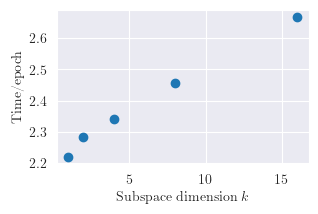

In [7]:
plt.scatter(x=[1,]+num_bends, y=np.array(walltimes)/num_epochs)
plt.xlabel(r"Subspace dimension $k$")
plt.ylabel("Time/epoch")

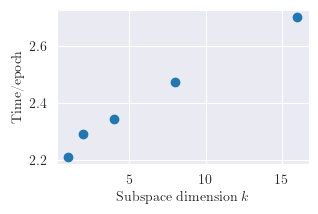

In [21]:
plt.scatter(x=[1,]+num_bends, y=np.array(walltimes)/num_epochs)
plt.xlabel(r"Subspace dimension $k$")
plt.ylabel("Time/epoch")
plt.savefig("figures2/timeConsumption_vs_k.pdf")

0.027515685827835753 2.2588489264612615 0.9997110273836611 0.0002889726163388673 0.0004678458994605114
offset: 0.039


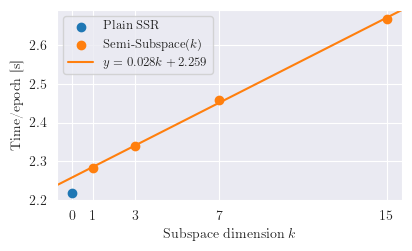

In [49]:
x = np.array([1,]+num_bends)-1
y = np.array(walltimes)/num_epochs
# df = pd.DataFrame({r"Subspace dimension $k$":np.array(num_bends)-1,
#                    "Time/epoch":np.array(walltimes[1:])/num_epochs})
# plot = sns.lmplot(data = df, x=r"Subspace dimension $k$", y="Time/epoch", height=figsize[0])

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(x[1:], y[1:])
print(slope, intercept, r_value, p_value, std_err)

plt.figure(figsize=np.array(figsize)*1.3)

# plt.xlim(0.)
ax = plt.scatter(x=x[:1], y=y[:1], label='Plain SSR')
ax = plt.scatter(x=x[1:], y=y[1:], label=r'$\text{Semi-Subspace}(k)$' )
plt.axline(xy1=(0, intercept), slope=slope, label=f'$y = {slope:.3f} k {intercept:+.3f}$', c=sns.color_palette()[1])

# plt.xlabel(r"Subspace dimension $k$")
plt.xticks(x)
plt.ylabel("Time/epoch [s]")
plt.xlabel(r"Subspace dimension $k$")
plt.legend()
plt.tight_layout()
plt.savefig("figures2/timeConsumption_vs_k.pdf", bbox_inches='tight')
print(f"offset: {intercept-y[0]:.3f}")

In [44]:
y[0]

2.219386854171753